In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import csv, warnings, math
import anchors
from poola import core as pool
from scipy.stats import ttest_ind
from scipy.interpolate import CubicSpline
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from adjustText import adjust_text

warnings.filterwarnings('ignore')
gpp.set_aesthetics(palette='Set2')


In [2]:
#Process data

def clean_data(df):
    '''
    Input: df: Reads dataframe with columns:
            - 0: Formatted as 'library_guide_gene' (e.g. 'HGLibA_00001_A1BG')
            - 1: Read counts 
    Output: df_clean: Dataframe with columns 'Guide', 'Gene Symbol', 'Reads'
    '''
    library_list = []
    guide_list = []
    gene_list = []
    for i, row in enumerate(df.iloc[:,0]):
        split_row = row.split('_')
        library = split_row[0]
        library_list.append(library)
        guide = split_row[1]
        guide_list.append(guide)
        gene = split_row[2]
        gene_list.append(gene)

    df_clean = pd.DataFrame()
    df_clean['Library'] = pd.Series(library_list)
    df_clean['Guide#'] = pd.Series(guide_list)
    df_clean['Guide'] = df_clean[['Library','Guide#']].apply(lambda x: '_'.join(x.dropna().values), axis=1)
    df_clean['Gene Symbol'] = pd.Series(gene_list)
    df_clean['Reads'] = df.iloc[:,1].copy()
    df_clean = df_clean.drop(['Library', 'Guide#'], axis = 1)
    return df_clean

def get_lognorm(df, cols = ['Reads'], new_col = ''):
    '''
    Inputs: 
    1. df: clean reads dataframe
    2. cols: list of names of column containing data used to calculate lognorm (default = ['Reads'])
    3. new_col: lognorm column name (optional) 
    Output: New dataframe with columns 'Gene Symbol', '[col]_Lognorm' (default = 'Reads_lognorm')
    '''
    df_lognorm = df.copy().drop(cols, axis = 1)
    for c in cols:
        #if not new_col: #if no lognorm column name specified 
        #df_lognorm[col+'_lognorm'] = np.log2(df[col]/df[col].sum()*1e6 +1)
        df_lognorm[c+'_lognorm'] = pool.lognorm(df[c])
        #else: 
            #df_lognorm[new_col] = np.log2(df[col]/df[col].sum()*1e6 +1)
            #df_lognorm[new_col] = pool.lognorm(df[c])
    return df_lognorm 

def col_avg(df, gene_col = ['Gene Symbol'], col_name = ''):
    avg_df = df[gene_col].copy()
    if col_name == '':
        #library = get_df_name(df).split('_')[-1] #get library name from df name
        avg_col_name = 'avg'#+library
    else:
        avg_col_name = col_name
    avg_df[avg_col_name] = df.mean(axis = 1)
    return avg_df

In [3]:
#QC 

def calculate_lfc(lognorm_df, target_cols, ref_col = 'pDNA_lognorm'): 
    '''
    Inputs:
    1. lognorm_df: Dataframe containing reference and target lognorm columns 
    2. target_cols: List containing target column name(s) (lognorm column(s) for which log-fold change should be calculated)
    3. ref_col: Reference column name (lognorm column relative to which log-fold change should be calculated)(default ref_col = 'pDNA_lognorm')
    '''
    #input df with lognorms + pDNA_lognorm
    lfc_df = pool.calculate_lfcs(lognorm_df=lognorm_df,ref_col='pDNA_lognorm', target_cols=target_cols)
    for col in target_cols: #rename log-fold change column so doesn't say "lognorm"
        lfc_col_name = col.replace('lognorm', 'lfc') 
        lfc_df = lfc_df.rename(columns = {col:lfc_col_name})
    return lfc_df

def get_controls(df, control_name = ['Non-Targeting'], separate = True):
    '''
    Inputs:
    1. df: Dataframe with columns "Gene Symbol" and data 
    2. control_name: list containing substrings that identify controls (default: 'NO_SITE', 'ONE_INTERGENIC')
    3. separate: determines whether to return non-targeting and intergenic controls separately (default = True)
    '''
    if len(control_name) == 1:
        control = df[df['Gene Symbol'].str.contains(control_name[0])]
        return control
    else:
        control_dict = {}
        for i, ctrl in enumerate(control_name):
            control_dict[ctrl] = df[df['Gene Symbol'].str.contains(ctrl)]
        if separate: 
            return control_dict

def get_gene_sets():
    '''
    Outputs: essential and non-essential genes as defined by Hart et al. 
    '''
    ess_genes = pd.read_csv('../Data/External/Gene_sets_Hart/essential-genes.txt', sep='\t', header=None)
    ess_genes.columns = ['Gene Symbol']
    ess_genes['ess-val'] = [1]*len(ess_genes)
    non_ess = pd.read_csv('../Data/External/Gene_sets_Hart/non-essential-genes.txt', sep='\t', header=None)
    non_ess.columns = ['Gene Symbol']
    non_ess['non-ess-val'] = [1]*len(non_ess)
    return ess_genes, non_ess

def merge_gene_sets(df):
    '''
    Input:
    1. df: data frame from which ROC-AUC is being calculated 
    Output:
    1. df: data frame with binary indicators for essential and non-essential genes 
    '''
    ess_genes, non_ess = get_gene_sets()
    df = pd.merge(df, ess_genes, on='Gene Symbol', how='left')
    df['ess-val'] = df['ess-val'].fillna(0)
    df = pd.merge(df, non_ess, on='Gene Symbol', how='left')
    df['non-ess-val'] = df['non-ess-val'].fillna(0)
    return df

def get_roc_auc(df, col):
    '''
    Inputs:
    1. df: data frame from which ROC-AUC is being calculated 
    2. col: column with data for which ROC-AUC is being calculated
    Outputs: 
    1. roc_auc: AUC value where true positives are essential genes and false positives are non-essential
    2. roc_df: dataframe used to plot ROC-AUC curve 
    '''
    df = df.sort_values(by=col)
    df['ess_cumsum'] = np.cumsum(df['ess-val'])
    df['non_ess_cumsum'] = np.cumsum(df['non-ess-val'])
    df['fpr'] = df['non_ess_cumsum']/(df['non_ess_cumsum'].iloc[-1])
    df['tpr'] = df['ess_cumsum']/(df['ess_cumsum'].iloc[-1])
    df.head()
    roc_auc = auc(df['fpr'],df['tpr'])
    roc_df = pd.DataFrame({'False_Positive_Rate':list(df.fpr), 'True_Positive_Rate':list(df.tpr)})
    return roc_auc, roc_df

def convertdftofloat(df):
    '''
    Converts df data column type into float 
    Input:
    1. df: data frame
    '''
    for col in df.columns[1:]:
        df[col] = df[col].astype(float) #convert dtype to float 
    return df

def new_rank_df(df, col = None, drop_col = True, ascending = False): #df with 2 cols "Gene Symbol" and scoring metric  
    '''
    Inputs:
    1. df: initial dataframe containing data that will be ranked
    2. col: column with data that will be ranked
    3. drop_col: bool indicating whether original data columns will be dropped in output df (default: True)
    4. ascending: direction of ranking (default: False)
    Output:
    rank_df: dataframe with ranked assigned to Gene Symbol 
    '''
    if not col:
        col = df.columns[1] #score column
    rank_df = pd.DataFrame()
    #print(col)
    rank_df = df.copy()[['Gene Symbol', col]]
    rank_df = df.sort_values(by = col, ascending = ascending).reset_index(drop = True) #column in descending order by default
    rank_col_name = 'Rank_' + col
    rank_df[rank_col_name] = rank_df.index + 1
    if drop_col: 
        rank_df = rank_df.copy().drop(col, axis = 1)
    rank_df = convertdftofloat(rank_df)
    return rank_df

def merge_dict_dfs(dictionary, merge_col = 'Gene Symbol', merge_how = 'inner', suffixes = ['_x', '_y']):
    '''
    Input: 1. dictionary: dictionary containing dataframes 
           2. merge_col: name of column on which dataframes will be merged (default = 'Gene Symbol')
           3. merge_how: type of merge (default = 'outer')
           4. suffixes: suffixes if two columns have the same name in dataframes being merged (default = ['_x','_y'])
            
    Output: merge1: merged dataframe 
    '''
    merge1 = pd.DataFrame()
    keys = []
    for df_name in dictionary.keys():
        keys.append(df_name)
    for i, df_name in enumerate(keys):
        current_df = dictionary[df_name]
        if (i+1 < (len(keys))): #stop before last df
            next_df_key = keys[i+1]
            next_df = dictionary[next_df_key]
            # merge dfs 
            if merge1.empty:  # if merged df does not already exist 
                merge1 = pd.merge(current_df, next_df, on = merge_col, how = merge_how, suffixes = suffixes)
                #print(merge1.columns)
            else: #otherwise merge next_df with previous merged df
                new_merge = pd.merge(merge1, next_df, on = merge_col, how = merge_how)
                merge1 = new_merge
        else: 
            continue
    return merge1

In [4]:
## Plotting functions
def pair_cols(df, initial_id = 'control', res_id = 'SARS', sep = '_', col_type = 'lfc'): #if more than one set of initial/resistant pop pairs, sharex = True, store pairs in list
    '''
    Inputs: 
    1. df: Dataframe containing log-fold change values and gene symbols 
    2. initial_id: string identifying initial column names (default: 'initial'), only used if multiple subplots
    3. col_type: string in names of columns containing data to be plotted (default: 'lfc')
    '''
    cols = [col for col in df.columns if col_type in col]
    pairs = [] #list of lists: ini/res pop pairs
    sharex = False
    if len(cols) > 2: #if more than one set of initial/resistant pop pairs 
        
        for index, col in enumerate(cols):
            pair = []
            if initial_id in col: #find corresponding resistant pop
                pair.append(col)
                split_col = col.split(sep)
                ini_index = split_col.index(initial_id)
                res_col_string = ' '.join(split_col[:ini_index])
                res_pop = [col for col in cols if res_id in col]

                for col in res_pop:
                    pair.append(col)
                    
                pairs.append(pair) #add to list of pairs (list of lists)
        if len(pairs) > 1:
            sharex = True # set sharex parameter for subplot 
        return sharex, pairs

    else: #if only one pair of initial/resistant pops
        sharex = False
        pairs.append(cols)
        return sharex, pairs

    
def lfc_dist_plot(chip_lfc, initial_id = 'control', res_id = 'SARS', ref_map = None, filename = '', figsize = (6,4)): #kde plots of population distribution (initial, resistant)
    '''
    Inputs: 
        1. chip_lfc: Dataframe containing log-fold change values and gene symbols 
        Option 1:
        2. initial_id: substring in names of column containing log-fold changes of uninfected population
        3. res_id: substring in names of column containing log-fold changes of infected population
        Option 2:
        4. ref_map: Dataframe with two columns: 
                    -'initial': (string) name of column containing log-fold changes of uninfected population
                    -'resistant': list name(s) of column(s) containing log-fold changes of infected population
                        --> if there's more than one resistant population corresponding to the same initial population,
                            store as list in same cell 
        _____
        5. filename: string for file name when saving figure 
        6. figsize: default (6,4)
        
    Outputs: kde plots of population distribution (initial, resistant)
    '''
        
    if not ref_map:
        sharex, lfc_pairs = pair_cols(chip_lfc, initial_id = 'control', res_id = 'SARS')
        
    fig, ax = plt.subplots(nrows = len(lfc_pairs), ncols = 1, sharex = sharex, figsize = figsize)
    
    i = 0 # ax index if have to plot multiple axes
    for k,c in enumerate(lfc_pairs):
        
        for l, c1 in enumerate(c):
            #title ex. Calu-3 Calabrese A screen 1, (k+1 = screen #)
            if not filename:
                title = ' '.join(c1.split(' ')[:3]) + ' (populations)'
            else:
                title = filename
            if l==0:
                label1 = c1
            else:
                #label1 = 'Resistant population-'+str(l)
                label1 = c1
                
            if sharex: #if multiple axes, ax = ax[i]
                chip_lfc[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=label1, ax=ax[i], legend=True)
                t = ax[i].set_xlabel('Log-fold changes') 
                t = ax[i].set_title(title)
            else: 
                chip_lfc[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=label1, ax=ax, legend=True)
                t = ax.set_xlabel('Log-fold changes')
                t = ax.set_title(title)
        i+=1
        sns.despine()   
    filepath = '../Figures/' + filename + '_popdist.png'
    print(filepath)
    fig.savefig(filepath, bbox_inches = 'tight')
    
#Control distributions
def control_dist_plot(chip_lfc, initial_id = 'control', res_id = 'SARS', no_site = 'Non-Targeting', filename = '', figsize = (6,4)): #kde plots of control distributions (initial, resistant)
    '''
    Inputs: 
        1. chip_lfc: Dataframe containing log-fold change values and gene symbols 
        2. control_name: list containing substrings that identify controls 
        3. initial_id: (string) name of column containing log-fold changes of uninfected population
        4. res_id: list name(s) of column(s) containing log-fold changes of infected population
        5. filename: string for file name used to save plot 
        6. figsize: size of plot (default: (6, 4))
                            
    Outputs: kde plots of control distributions (initial, resistant)
    '''
    sharex, lfc_pairs = pair_cols(chip_lfc, initial_id= initial_id, res_id=res_id)
    nosite = get_controls(chip_lfc, [no_site])
    nrows = len(lfc_pairs)
    
    fig, ax = plt.subplots(nrows = nrows, ncols = 1, sharex = sharex, figsize = figsize)

    i = 0 # ax index if have to plot multiple axes
    for k,c in enumerate(lfc_pairs): # k=screen, c=ini, res pair 
        for l, c1 in enumerate(c): # l = ini or res, c1 = pop label 
            title = c1 + ' (controls)'
            pop_label = c1.split(' ')[0] #labels 'initial' or 'resistant'
            #Plot same screen on same subplot 
            if sharex: #if multiple axes, ax = ax[i]
                nosite[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label='Non-targeting ('+pop_label+')', ax=ax[i], legend=True)
                
                ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                sns.despine()
                t = ax[i].set_xlabel('Log-fold changes')
                t = ax[i].set_title(title)
            else: 
                nosite[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label='Non-targeting ('+pop_label+')', ax=ax, legend=True)
                ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                sns.despine()
                t = ax.set_xlabel('Log-fold changes')
                t = ax.set_title(title)
        i+=1 #switch to next subplot for next screen

        sns.despine()

    filepath = '../Figures/' + filename + '_controldist.png'
    print(filepath)
    fig.savefig(filepath, bbox_inches = 'tight')
    


In [5]:
def run_guide_residuals(lfc_df):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Input:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    paired_lfc_cols = pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots

#Modify so combine on gene_col only and not condition_col

import statsmodels
from scipy import stats
from anchors.score import aggregate_guide_residuals

def aggregate_guide_residuals(mapped_guide_residuals, gene_col, construct_col):
    """Combine guide residuals at the gene level
    Parameters
    ----------
    mapped_guide_residuals: DataFrame
        Guide residuals mapped to genes
    gene_col: str
        Name of column with genes
    construct_col: str
        Name of column with constructs
    Returns
    -------
    DataFrame
        Gene summarized residuals
    """
    gene_residuals = (mapped_guide_residuals.groupby([gene_col])
                      .agg(sum_z=('residual_z', 'sum'),
                           guides=(construct_col, 'nunique'),
                           avg_lfc=('lfc', 'mean'),
                           avg_lfc_reference=('lfc_reference', 'mean'))
                      .reset_index())
    gene_residuals['residual_zscore'] = gene_residuals['sum_z'] / np.sqrt(gene_residuals['guides'])
    gene_residuals = gene_residuals.drop('sum_z', axis=1)
    gene_residuals['p_value'] = stats.norm.sf(abs(gene_residuals.residual_zscore)) * 2
    gene_residuals['fdr_bh'] = (gene_residuals.groupby('Gene Symbol')
                                .p_value
                                .transform(lambda x: statsmodels.stats.multitest.multipletests(x, method='fdr_bh')[1]))
    return gene_residuals

def get_gene_residuals(guide_residuals, guide_mapping):
    """Combine guide residuals at the gene level
    Parameters
    ----------
    guide_residuals: DataFrame
        Results from get_guide_residuals
    guide_mapping: DataFrame
        Mapping between guides and genes. The
        first column should identify sgRNAs and the second column should identify gene symbols
    Returns
    -------
    """
    anchors.score.check_gene_inputs(guide_residuals, guide_mapping)
    mapping_construct_col = guide_mapping.columns[0]
    mapping_gene_col = guide_mapping.columns[1]
    residual_construct_col = guide_residuals.columns[0]
    mapped_guide_residuals = anchors.score.merge_residual_mapping(guide_residuals, guide_mapping, residual_construct_col,
                                                    mapping_construct_col)
    gene_residuals = aggregate_guide_residuals(mapped_guide_residuals, mapping_gene_col, residual_construct_col)
    return gene_residuals

def format_gene_residuals(df, guide_min = 3, guide_max = 5):
    '''
    Inputs: 
    1. df: gene_residuals output df 
    2. guide_min: min number of guides per gene to filter df
    3. guide_max: max number of guides per gene to filter df
    4. ascending: direction to sort df 
    Outputs:
    1. df_z: dataframe with the following columns: 
            -Gene Symbol
            -residual_zscore: residual_zscores averaged across conditions 
            -Rank_residual_zscore: 
    '''
    df = df[(df['guides']>=guide_min) & (df['guides']<=guide_max)]
    conditions = list(set(df.loc[:, 'condition']))
    print(conditions)
    if len(conditions) > 1:
        df_z = df[['condition', 'Gene Symbol', 'residual_zscore']]
        condition_dict = {}
        for i, c in enumerate(conditions):
            print(c)
            condition_dict[c] = df_z[df_z['condition'] == c]
        #print(condition_dict) 
        merged_df_z = merge_dict_dfs(condition_dict)
        merged_df_z['residual_zscore_avg'] = merged_df_z.mean(axis = 1)
        #condition_cols = [col for col in merged_df_z.columns if 'condition' in col]
        df_z = merged_df_z.copy()[['Gene Symbol', 'residual_zscore_avg']]
        df_z = new_rank_df(df_z, 'residual_zscore_avg', drop_col=False)
    else:
        df_z = new_rank_df(df_z, 'residual_zscore', drop_col=False)
        
    return df_z



## Data Summary

* Schneider et al.
* Cell line: Huh 7.5
* Library: Brunello

In [6]:
#Read counts
reads_raw = pd.read_csv('../Data/Reads/Poirier/ReadCounts_Poirier.txt', sep = '\t')
#seasonal coronavirus data + mock also included, will drop for now
NL63_cols = [col for col in reads_raw.columns if 'NL63' in col]
OC43_cols = [col for col in reads_raw.columns if 'OC43' in col]
_229E_cols = [col for col in reads_raw.columns if '229E' in col]
#mock_cols = [col for col in reads_raw.columns if 'Mock' in col]
cols_to_drop = NL63_cols+OC43_cols+_229E_cols

reads = reads_raw.copy().drop(cols_to_drop, axis = 1)
base_reads = reads[['sgRNA', 'Gene', 'Brunello_Plasmid_DNA_library', 'Brunello_Huh75_Day0']]

#average replicates for temperature conditions 
link_cols = ['sgRNA', 'Gene']
mock_cols = [col for col in reads_raw.columns if 'Mock' in col]
mock_cols = link_cols + mock_cols
mock_reads = reads[mock_cols]
mock_avg = col_avg(mock_reads, gene_col = link_cols, col_name = 'Mock_control')

# columns for 33 degrees Celsius condition 
cols_33 = ([col for col in reads.columns if '33' in col])
cols_33 = link_cols + cols_33
reads_33 = reads[cols_33]
reads_33_avg = col_avg(reads_33, gene_col = link_cols, col_name = '33C_SARS_CoV2')
reads_33_avg

# columns for 37 degrees Celsius condition 
cols_37 = ([col for col in reads.columns if '37' in col])
cols_37 = link_cols + cols_37
reads_37 = reads[cols_37]
reads_37_avg = col_avg(reads_37, gene_col = link_cols, col_name = '37C_SARS_CoV2')

sars_reads = pd.merge(reads_33_avg, reads_37_avg, on = link_cols, how = 'outer')

reads_clean1 = pd.merge(base_reads, mock_avg, on = link_cols, how = 'outer')
reads_clean = pd.merge(reads_clean1, sars_reads, on = link_cols, how = 'outer')
reads_clean = reads_clean.rename(columns={'sgRNA': 'Guide', 'Gene': 'Gene Symbol', 'Brunello_Plasmid_DNA_library': 'pDNA', 'Brunello_Huh75_Day0':'Day0_control'})
reads_clean

,Guide,Gene Symbol,pDNA,Day0_control,Mock_control,33C_SARS_CoV2,37C_SARS_CoV2
0,CHDH_GTGCCCACGGACGTAGACCA,CHDH,207,137,350.666667,244.333333,182.000000
1,FBXO11_AACCACTGTAGGGTTAGCAT,FBXO11,115,76,19.333333,46.000000,36.666667
2,NUMBL_ATGGCAGCTCATTCAGCCGT,NUMBL,52,45,87.333333,52.333333,20.666667
3,RXFP4_CTGGGCCCGAATAGCCACCC,RXFP4,89,45,65.666667,93.000000,68.666667
4,NR3C1_ATCAACAGGTCTGATCTCCA,NR3C1,109,99,169.000000,165.666667,123.666667
...,...,...,...,...,...,...,...
77436,HGC6.3_TCTCCTCCCCACACACTGCA,HGC6.3,0,0,0.000000,0.000000,0.000000
77437,LOC100130357_TCTCCCGCTTCTCCACTCCG,LOC100130357,0,0,0.000000,0.000000,0.000000
77438,C17orf99_TCTCCCAGAAATTACCCCTG,C17orf99,0,0,0.000000,0.000000,0.000000
77439,NTC_CCGTCTCCGCATCGTCTTTT,Non-Targeting_124,0,0,0.000000,0.000000,0.000000


In [7]:
reads_clean[['Guide', 'Gene Symbol', 'pDNA']].to_excel('../Data/Reads/Poirier/Poirier_Brunello_pDNA.xlsx', index = False)

In [8]:
#Calculate lognorm
cols = reads_clean.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = get_lognorm(reads_clean.dropna(), cols = cols)
lognorms

,Guide,Gene Symbol,pDNA_lognorm,Day0_control_lognorm,Mock_control_lognorm,33C_SARS_CoV2_lognorm,37C_SARS_CoV2_lognorm
0,CHDH_GTGCCCACGGACGTAGACCA,CHDH,5.251061,5.209091,5.874969,5.238886,5.406556
1,FBXO11_AACCACTGTAGGGTTAGCAT,FBXO11,4.433057,4.389955,2.063662,2.985718,3.224040
2,NUMBL_ATGGCAGCTCATTCAGCCGT,NUMBL,3.366734,3.680523,3.941755,3.149603,2.511716
3,RXFP4_CTGGGCCCGAATAGCCACCC,RXFP4,4.082680,3.680523,3.561033,3.906203,4.055372
4,NR3C1_ATCAACAGGTCTGATCTCCA,NR3C1,4.359423,4.755308,4.848078,4.696346,4.865029
...,...,...,...,...,...,...,...
77436,HGC6.3_TCTCCTCCCCACACACTGCA,HGC6.3,0.000000,0.000000,0.000000,0.000000,0.000000
77437,LOC100130357_TCTCCCGCTTCTCCACTCCG,LOC100130357,0.000000,0.000000,0.000000,0.000000,0.000000
77438,C17orf99_TCTCCCAGAAATTACCCCTG,C17orf99,0.000000,0.000000,0.000000,0.000000,0.000000
77439,NTC_CCGTCTCCGCATCGTCTTTT,Non-Targeting_124,0.000000,0.000000,0.000000,0.000000,0.000000


## Quality Control
### Population Distributions

../Figures/Huh75_Brunello_popdist.png


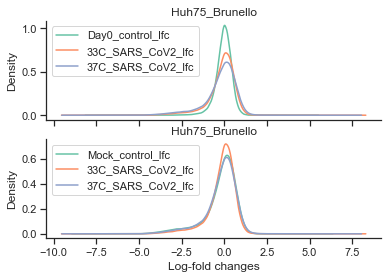

In [9]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = calculate_lfc(lognorms,target_cols)
#Plot population distributions of log-fold changes 
lfc_dist_plot(pDNA_lfc, filename = 'Huh75_Brunello')

### Control Distributions

../Figures/Huh75_Brunello_controldist.png


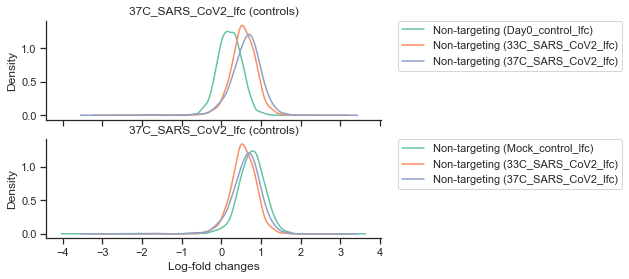

In [10]:
control_dist_plot(pDNA_lfc, initial_id= 'control', res_id='SARS', no_site='Non-Targeting', filename='Huh75_Brunello')

### ROC-AUC

Text(0, 0.5, 'True Positive Rate (essential)')

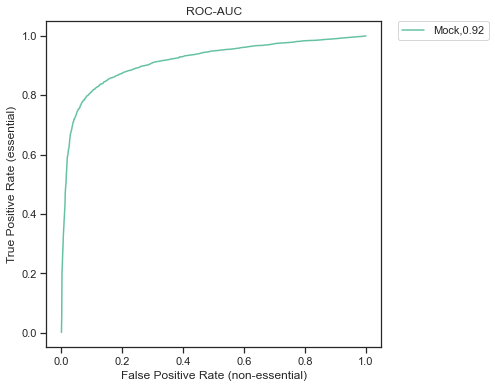

In [11]:
ess_genes = pd.read_csv('../Data/External/Gene_sets_Hart/essential-genes.txt', sep = '\t', header = None)
tp_genes = ess_genes[0].to_list()
non_ess_genes = pd.read_csv('../Data/External/Gene_sets_Hart/non-essential-genes.txt', sep = '\t', header = None)
fp_genes = non_ess_genes[0].to_list()
fp_genes
# for key, df in control_lfc_df_dict.items():
# lfc_pair = pair_cols(pDNA_lfc)[1]
roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col='Mock_control_lfc')


fig,ax=plt.subplots(figsize=(6,6))
ax=sns.lineplot(data=roc_df, x='fpr',y='tpr', ci=None, label = 'Mock,' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene-level analysis

### Residual z-scores

In [12]:
#Calculate z-scores of lfc residuals
lfc_df = pDNA_lfc.copy().drop(['Gene Symbol'], axis = 1)
lfc_df = lfc_df.dropna()

# guide_residuals_day0_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df.drop('Mock_control_lfc', axis = 1))
guide_residuals_mock_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df.drop('Day0_control_lfc', axis = 1))

guide_mapping = pDNA_lfc[['Guide', 'Gene Symbol']]

# gene_residuals_day0 = anchors.get_gene_residuals(guide_residuals_day0_lfcs, guide_mapping)
gene_residuals_mock = anchors.get_gene_residuals(guide_residuals_mock_lfcs, guide_mapping)


            modified       unperturbed
0  33C_SARS_CoV2_lfc  Mock_control_lfc
1  37C_SARS_CoV2_lfc  Mock_control_lfc


In [13]:
# gene_residual_sheet_day0 = format_gene_residuals(gene_residuals_day0)
gene_residual_sheet_mock = format_gene_residuals(gene_residuals_mock)
# guide_residual_sheet_day0 = pd.merge(guide_mapping, guide_residuals_day0_lfcs, on = 'Guide', how = 'outer')
guide_residual_sheet_mock = pd.merge(guide_mapping, guide_residuals_mock_lfcs, on = 'Guide', how = 'outer')


['33C_SARS_CoV2_lfc', '37C_SARS_CoV2_lfc']
33C_SARS_CoV2_lfc
37C_SARS_CoV2_lfc


In [14]:
with pd.ExcelWriter('../Data/Processed/GEO_submission/Huh75_Brunello_Poirier.xlsx') as writer:  
    gene_residual_sheet_mock.to_excel(writer, sheet_name='Huh75_Brunello_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='Huh75_Brunello_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='Huh75_Brunello_guide_mapping', index =False)

In [16]:
with pd.ExcelWriter('../Data/Processed/Individual_screens/Huh75_Brunello_Poirier_v2.xlsx') as writer:   
    gene_residuals_mock.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet_mock.to_excel(writer, sheet_name='guide-level_zscore', index =False)